# Notebook for practical exercises | Week #2 Lesson #1

## Introduction

This notebook contains practical hands-on exercises for the lesson about *Data Collection and Cleaning Techniques*.

After this session, you will know how to prepare a medical imaging dataset for training:
* Import and read medical images using Python ;
* Extract relevant radiomic features ;
* Clean data: handle missing values, normalize features.

## Dataset

In the following, we will use the [The Brain Resection Multimodal Imaging Database](https://www.cancerimagingarchive.net/collection/remind/) [1]. The Brain Resection Multimodal Imaging Database (ReMIND) contains pre- and intra-operative brain MRI collected on 114 consecutive patients who were surgically treated with image-guided tumor resection between 2018 and 2022.

[1] Juvekar, P., Dorent, R., Kögl, F., Torio, E., Barr, C., Rigolo, L., Galvin, C., Jowkar, N., Kazi, A., Haouchine, N., Cheema, H., Navab, N., Pieper, S., Wells, W. M., Bi, W. L., Golby, A., Frisken, S., & Kapur, T. (2023). The Brain Resection Multimodal Imaging Database (ReMIND) (Version 1) [dataset]. The Cancer Imaging Archive. [https://doi.org/10.7937/3RAG-D070](https://doi.org/10.7937/3RAG-D070)

In [1]:
!git clone https://github.com/albarqounilab/AIM.git

Cloning into 'AIM'...
remote: Enumerating objects: 860, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 860 (delta 53), reused 72 (delta 26), pack-reused 758 (from 2)
Receiving objects: 100% (860/860), 217.64 MiB | 24.86 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Updating files: 100% (89/89), done.


In [2]:
# install dependencies
!pip install pydicom pynrrd SimpleITK pyradiomics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 47.5 MB/s eta 0:00:00


In [5]:
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from glob import glob
from radiomics import featureextractor

import sys
# Correct the path to the utils module based on the cloned AIM directory
sys.path.append('/content/AIM')
from utils.sitk_utils import load_dicom_series_to_3d_image, convert_np_to_sitk, reconstruct_mask_in_image_space

### Download

Run the following cells to download and unzip the dataset.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the data folder. By default, it will be stored at the root of this repository.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [8]:
DATA_PATH = '/content'
!curl https://uni-bonn.sciebo.de/s/s1t8QUZ02MF1Qoh/download --output {DATA_PATH}/data.zip # to download the data
!unzip {DATA_PATH}/data.zip # To unzip the folder

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1730M  100 1730M    0     0  28.6M      0  0:01:00  0:01:00 --:--:-- 23.0M
Archive:  /content/data.zip
replace data/ReportsDATASET.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Metadata

In [9]:
# Load and observe available data
clinical_df = pd.read_csv(f'{DATA_PATH}/data/ReMIND/ReMIND_metadata.csv')
clinical_df.head() # Print the 5 fist rows of the dataframe

,Case Number,Age,Sex,Race,Ethnicity,Laterality,Previous Craniotomy,WHO Grade,Histopathology
0,1,41,Male,White,Not Hispanic,Right,No,3,Astrocytoma
1,2,22,Female,White,Not Hispanic,Right,No,2,Astrocytoma
2,3,30,Male,Asian,Not Hispanic,Left,No,2,Oligodendroglioma
3,4,23,Male,White,Hispanic,Left,No,1,Dysembryoplastic neuroepithelial tumor
4,5,27,Male,White,Not Hispanic,Right,No,Not assigned,Non-tumor epileptogenic brain parenchyma and g...


In [10]:
# Observe variables
clinical_df.columns

Index(['Case Number', 'Age', 'Sex', 'Race', 'Ethnicity', 'Laterality',
       'Previous Craniotomy', 'WHO Grade', 'Histopathology'],
      dtype='object')

We aim to train a model using pre-operative brain MRI scans to classify tumor grade (column **WHO Grade**). To do so, we need to make sure that the features we will be using are correct.

<div class="alert alert-block alert-info">
<b>Q1.</b> Observe the unique values in column <b>WHO Grade</b>, and identify issues that should be corrected.
</div>


In [11]:
clinical_df['WHO Grade'].unique() # To observe the different labels in this column

array(['3', '2', '1', 'Not assigned', '4'], dtype=object)

The column WHO Grade contains "Not Assigned", ane we need to remove it.

The column contains `Not assigned` values. We need to drop the corresponding samples.

In [13]:
clinical_df = clinical_df.loc[clinical_df['WHO Grade']!='Not assigned'] # COMPLETE with the label to remove

In [14]:
clinical_df['WHO Grade'].unique() # No more missing values

array(['3', '2', '1', '4'], dtype=object)

### Images

Now that we have a dataframe containing only samples that can be used for the classification, we need to find the corresponding image.
The column **Case Number** (sometimes also called **ID** in standard dataframes) provides a unique identifier for each patient. Now, our goal will be to link the images to their corresponding rows in the dataframes.

In [15]:
sorted(glob(f'{DATA_PATH}/data/ReMIND/*'))[0:5] # This command looks for folders within the dataset and displays the 5 first

['/content/data/ReMIND/LICENSE',
 '/content/data/ReMIND/ReMIND_metadata.csv',
 '/content/data/ReMIND/sub-001',
 '/content/data/ReMIND/sub-002',
 '/content/data/ReMIND/sub-003']

In the dataset, each folder is named **ReMIND-XXX**, which **XXX** representing the corresponding patient ID. Now, we will explore the content of a patient folder.

Folders are organized in the following way:
```bash
sub-001/                     # Subject-level folder          
└── anat/                    # Structural MRI
    └── T1w/                 # T1w sequence
        ├── 1-001.dcm        # Images in DICOM format
        ├── 1-002.dcm
        ├── 1-003.dcm
        └── ...
└── seg/
```

In the following, we will focus on pre-operative T1 gadolinium enhanced MRI, which can be used to identify and locate tumors.
The images are located in a folder containing the label **3DAXT1postcontrast** for each patient.

Now, let's verify if we have an image for each patient in our dataframe.

In [16]:
for patient in clinical_df['Case Number']:
    idx = str(patient).zfill(3)

    if len(glob(f'{DATA_PATH}/data/ReMIND/sub-{idx}/anat/T1w')) == 0:
        print('No T1w image for patient n.', idx)

No T1w image for patient n. 012
No T1w image for patient n. 032
No T1w image for patient n. 033
No T1w image for patient n. 040
No T1w image for patient n. 065
No T1w image for patient n. 087
No T1w image for patient n. 091
No T1w image for patient n. 096


Eight patients do not have pre-operative T1w images. We will thus have to remove them from the list when computing the features.

Now, we will explore the structure of a DICOM file, and how we can read it with Python.

In [17]:
t1w_file = glob(f'{DATA_PATH}/data/ReMIND/sub-001/anat/T1w/1-080.dcm')[0]
image = pydicom.dcmread(t1w_file)

The dcmread function from the pydicom library allows to read DICOM files and store their content in a Python object. Let's explore its different attributes.

In [18]:
image

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.241234373646560912433565108058941598584
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'MPR']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.241234373646560912433565108058

We can access DICOM headers' information using their name. For instance, to obtain the image type, run `image.ImageType`

<div class="alert alert-block alert-info">
<b>Q2.</b> Explore other informations contained in DICOM headers using similar commands.
</div>

In [19]:
image.ImageType # COMPLETE with the attribute you want to observe

['ORIGINAL', 'PRIMARY', 'MPR']

Now, we will try to better understand how the images are stored. We can see in the header that we have images of dimension 256 x 216 (see attributes `Rows` and `Columns`). In Python, this means that the image corresponds to an **array** with 256 rows and 216 columns, with each **cell** corresponding to the pixel intensity value. This array is stored in the attribute `pixel_array` of the image, and the `matplotlib` library allows to plot images stored as pixel intensity arrays.

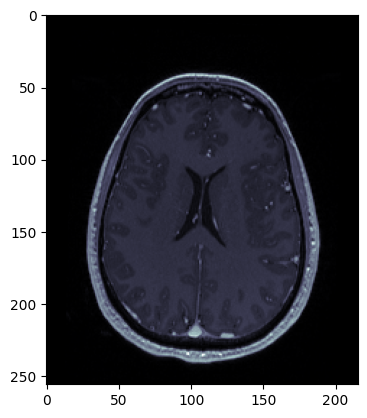

In [20]:
plt.imshow(image.pixel_array, cmap=plt.cm.bone)
plt.show()

Note that the images are 3D volumes, but DICOM files only contain slices. To load the full volume in a single array, we would have to loop over the slices and stack them to create a full volume. In practice, we will prefer to use `NIfTI` files (see practical session of Lesson 3 for more details).

In [21]:
# First use pre-defined function to load dicom series to 3D images, load mask and resample the mask to the image space
image_sitk = load_dicom_series_to_3d_image(
    glob(f'{DATA_PATH}/data/ReMIND/sub-001/anat/T1w')[0]) # !!! We use the path of the FOLDER, not the list of images

[INFO] Loaded DICOM series with size: (216, 256, 192)


### Derivatives

The dataset we are using contains segmentation masks stored in **NRRD** format. These segmentation masked have been drawn manually by two neurosurgeons, and represent the boundaries of the tumor identified using the pre-operative MRI. In Lesson 3, we will see how you could generate these annotations by yourself.

Similarly to T1w images, we will verify that all patients have a pre-operative segmentation of the tumor region.

In [22]:
for patient in clinical_df['Case Number']:
    idx = str(patient).zfill(3)

    if len(glob(f'{DATA_PATH}/data/ReMIND/sub-{idx}/seg/ReMIND-{idx}-preop-SEG-tumor*.nrrd')) == 0:
        print('No pre-operative tumor segmentation for patient n.', idx)

No pre-operative tumor segmentation for patient n. 012
No pre-operative tumor segmentation for patient n. 032
No pre-operative tumor segmentation for patient n. 033
No pre-operative tumor segmentation for patient n. 040
No pre-operative tumor segmentation for patient n. 065
No pre-operative tumor segmentation for patient n. 087
No pre-operative tumor segmentation for patient n. 091
No pre-operative tumor segmentation for patient n. 096


To load NRRD files, we will use the `SimpleITK` package.

In [23]:
seg_file = glob(f'{DATA_PATH}/data/ReMIND/sub-001/seg/ReMIND-001-preop-SEG-tumor*.nrrd')[0]

reader = sitk.ImageFileReader() # Create a file reader
reader.SetImageIO("NrrdImageIO") # Set the input type
reader.SetFileName(seg_file) # Set the file name
mask_sitk = reader.Execute() # Load

<div class="alert alert-block alert-info">
<b>Q3.</b> Visualize the dimensions of the mask using the <code>GetSize()</code> function. What do you notice? How is this different from the DICOM image?
</div>

In [24]:
print('Mask shape:', mask_sitk.GetSize())
print('Image shape', image_sitk.GetSize())

Mask shape: (61, 63, 59)
Image shape (216, 256, 192)


Mask and Image have different shapes. the Mask is coming from a CROP images causing this differnence.With SITK, the origin in physical space, the spacing and space directions allow us to recnstruct the mask in image space.

Now, we will reconstruct the mask in image space and visualize the results.

In [27]:
mask_sitk_rec = reconstruct_mask_in_image_space(mask_sitk, image_sitk)

[INFO] Loaded mask with size: (61, 63, 59)


In [28]:
# Verify that the shape has been corrected
print('Mask shape:', mask_sitk_rec.GetSize())
print('Image shape', image_sitk.GetSize())

Mask shape: (216, 256, 192)
Image shape (216, 256, 192)


<div class="alert alert-block alert-info">
<b>Q4.</b> Use the same function as below to plot the image and the mask slices and visualize their content.
</div>

In [29]:
image_slice = sitk.GetArrayFromImage(image_sitk)[110] # COMPLETE with the slice you want to visualize
mask_slice = sitk.GetArrayFromImage(mask_sitk_rec)[110]

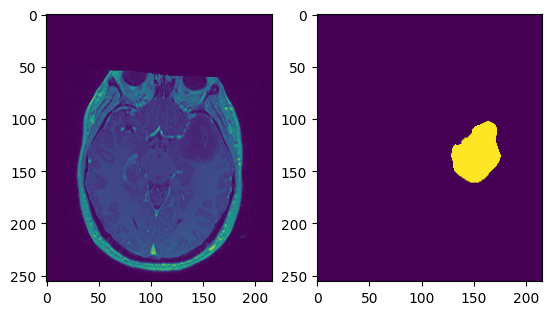

In [30]:
... # COMPLETE with plotting functions
f, ax = plt.subplots(1,2)
ax[0].imshow(image_slice)
ax[1].imshow(mask_slice)
plt.show()

As you might have noticed, the function to read the file contains several attributes. The header contains information about the image:
* size ;
* space directions ;
* origin ;
* ...

In [31]:
print('Origin:', image_sitk.GetOrigin()) # Origin in physical space
print('Dimensions:', image_sitk.GetSize()) # Shape
print('Directions:', image_sitk.GetDirection()) # Affine matrix

Origin: (150.248, -123.123, 68.3235)
Dimensions: (216, 256, 192)
Directions: (-0.7521951128278977, -0.6489012317876394, -0.1145849188257806, -0.6521878409159783, 0.7579752707489061, -0.011158364328042996, 0.09409321122791484, 0.06633762369581139, -0.9933507876290288)


## Feature extraction

Now that we observed the different data, we will extract radiomic features and visualize these features.
To do so, we will use `SimpleITK` to load images, and `pyradiomics` to extract features. The idea is that, given an image and a corresponding mask, the code will extract relevant metrics.

A detailed description of each metrics is available at [https://pyradiomics.readthedocs.io/en/latest/features.html](https://pyradiomics.readthedocs.io/en/latest/features.html).

We will now create the feature extractor and apply it to **the previously reconstructed image-mask pair**.
We can define specific parameters for the feature extraction. In our case, we will add a **standard normalization space**, aiming mitigate pixel intensity differences across MRI machines.

In [32]:
settings = {}

# Normalizes the image by centering it at the mean with standard deviation.
# Normalization is based on all gray values in the image, not just those inside the segmentation.
settings['normalize'] = True

# Create the featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'normalize': True}


In [33]:
# Extract features
result = extractor.execute(image_sitk, mask_sitk_rec)

INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


In [34]:
result

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '2.0.2'),
             ('diagnostics_Versions_SimpleITK', '2.5.2'),
             ('diagnostics_Versions_PyWavelet', '1.8.0'),
             ('diagnostics_Versions_Python', '3.11.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': True,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diagno

<div class="alert alert-block alert-info">
<b>Q5.</b> Analyse the extracted features. Identify potential attributes that could be useful to classify the tumor grade.
</div>

In [35]:
result['original_shape_VoxelVolume'] # example: tumor voxel volume, uniformity, etc.

np.float64(75844.94136532053)

In [36]:
result['original_glcm_JointEntropy']

array(0.78419256)

<div class="alert alert-block alert-info">
<b>Q6.</b> Implement and run the feature extraction without normalization and compare the results.
</div>

In [38]:
# Without normalization
settings = {}

# Normalizes the image by centering it at the mean with standard deviation.
# Normalization is based on all gray values in the image, not just those inside the segmentation.
settings['normalize'] = False

# Create the featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
result_nn = extractor.execute(image_sitk, mask_sitk_rec)
result_nn

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'normalize': False}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '2.0.2'),
             ('diagnostics_Versions_SimpleITK', '2.5.2'),
             ('diagnostics_Versions_PyWavelet', '1.8.0'),
             ('diagnostics_Versions_Python', '3.11.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diagn

Now that we better understand how to extract radiomic features from DICOM files associated with tumor masks, we will apply this to the whole dataset and transform the results to a csv file.

In [39]:
feature_list = []

# Loop over patients
for patient, tumor in zip(clinical_df['Case Number'], clinical_df['WHO Grade']):
    # Use pre-defined function to load dicom series to 3D images, load mask and resample the mask to the image space
    idx = str(patient).zfill(3)
    print(idx)
    img_dirname = glob(f'{DATA_PATH}/data/ReMIND/sub-{idx}/anat/T1w')
    seg_fname = glob(
        f'{DATA_PATH}/data/ReMIND/sub-{idx}/seg/ReMIND-{idx}-preop-SEG-tumor-*.nrrd')

    if len(img_dirname) == 0 or len(seg_fname)==0:
        continue # Allows to skip subjects without image or without segmentation

    image_sitk = load_dicom_series_to_3d_image(img_dirname[0])
    reader = sitk.ImageFileReader() # Create a file reader
    reader.SetImageIO("NrrdImageIO") # Set the input type
    reader.SetFileName(seg_fname[0]) # Set the file name
    mask_sitk = reader.Execute() # Load
    mask_sitk_rec = reconstruct_mask_in_image_space(mask_sitk, image_sitk) # Reconstruct in image space

    result = extractor.execute(image_sitk, mask_sitk_rec)

    result['patient'] = patient
    result['tumor'] = tumor

    feature_list.append(result)

001
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (61, 63, 59)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


002


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (32, 49, 36)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


003
[INFO] Loaded DICOM series with size: (512, 512, 168)
[INFO] Loaded mask with size: (34, 27, 29)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


004


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (10, 7, 5)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


006
[INFO] Loaded DICOM series with size: (512, 512, 201)
[INFO] Loaded mask with size: (40, 71, 39)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


008
[INFO] Loaded DICOM series with size: (512, 512, 364)
[INFO] Loaded mask with size: (71, 57, 56)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


009
[INFO] Loaded DICOM series with size: (208, 256, 176)
[INFO] Loaded mask with size: (48, 73, 57)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


010
[INFO] Loaded DICOM series with size: (512, 512, 172)
[INFO] Loaded mask with size: (52, 50, 21)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


011


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (53, 74, 25)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


012
013


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (39, 78, 39)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


015
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (26, 31, 26)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


016


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (6, 6, 9)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


017


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 176)
[INFO] Loaded mask with size: (9, 9, 10)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


018


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (18, 40, 11)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


019


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (208, 256, 192)
[INFO] Loaded mask with size: (65, 89, 10)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


020


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (45, 70, 41)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


021


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (208, 256, 208)
[INFO] Loaded mask with size: (37, 53, 60)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


022


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (248, 256, 176)
[INFO] Loaded mask with size: (13, 16, 12)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


023
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (24, 21, 29)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


024
[INFO] Loaded DICOM series with size: (512, 512, 348)
[INFO] Loaded mask with size: (62, 89, 75)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


025


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (58, 74, 57)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


026
[INFO] Loaded DICOM series with size: (256, 256, 176)
[INFO] Loaded mask with size: (156, 139, 48)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


027


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (30, 38, 30)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


028


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 202)
[INFO] Loaded mask with size: (54, 63, 62)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


031
[INFO] Loaded DICOM series with size: (200, 256, 192)
[INFO] Loaded mask with size: (31, 31, 26)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


032
033
034


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 208)
[INFO] Loaded mask with size: (53, 68, 47)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


037
[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (38, 47, 43)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


039
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (41, 50, 40)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


040
041


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (200, 256, 192)
[INFO] Loaded mask with size: (17, 24, 19)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


044


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (19, 37, 22)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


045


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (43, 59, 38)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


046
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (38, 71, 46)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


047


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 176)
[INFO] Loaded mask with size: (10, 8, 8)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


048
[INFO] Loaded DICOM series with size: (560, 560, 174)
[INFO] Loaded mask with size: (86, 97, 12)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


049


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (29, 36, 41)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


050


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (49, 73, 35)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


051


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 151)
[INFO] Loaded mask with size: (16, 27, 29)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


052
[INFO] Loaded DICOM series with size: (512, 512, 192)
[INFO] Loaded mask with size: (63, 119, 41)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


053
[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (41, 51, 11)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


054
[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (73, 83, 58)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


055
[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (34, 30, 20)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


056
[INFO] Loaded DICOM series with size: (512, 512, 192)
[INFO] Loaded mask with size: (55, 76, 42)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


057


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (38, 67, 40)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


058


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 166)
[INFO] Loaded mask with size: (251, 140, 120)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


059


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (208, 256, 176)
[INFO] Loaded mask with size: (92, 76, 76)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


060


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (19, 75, 54)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


062
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (42, 56, 40)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


063
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (44, 51, 51)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


065
066


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 208)
[INFO] Loaded mask with size: (49, 57, 59)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


067


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 208)
[INFO] Loaded mask with size: (43, 68, 44)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


068


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 176)
[INFO] Loaded mask with size: (40, 29, 32)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


069


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (33, 20, 21)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


070


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (71, 85, 71)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


071
[INFO] Loaded DICOM series with size: (432, 512, 176)
[INFO] Loaded mask with size: (99, 126, 55)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


074


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (52, 80, 50)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


075


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (232, 256, 192)
[INFO] Loaded mask with size: (24, 28, 24)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


076
[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (60, 73, 51)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


077


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (12, 16, 7)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


078


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 168)
[INFO] Loaded mask with size: (19, 35, 5)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


079
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (18, 20, 19)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


080


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (62, 75, 65)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


081


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (27, 43, 39)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


082


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 176)
[INFO] Loaded mask with size: (28, 67, 58)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


083


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 208)
[INFO] Loaded mask with size: (35, 45, 40)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


085


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (232, 256, 176)
[INFO] Loaded mask with size: (42, 61, 41)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


086


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (41, 32, 32)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


087
088
[INFO] Loaded DICOM series with size: (256, 256, 408)
[INFO] Loaded mask with size: (103, 186, 83)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


089
[INFO] Loaded DICOM series with size: (256, 256, 192)
[INFO] Loaded mask with size: (9, 7, 10)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


091
092
[INFO] Loaded DICOM series with size: (512, 512, 276)
[INFO] Loaded mask with size: (75, 132, 8)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


093
[INFO] Loaded DICOM series with size: (480, 640, 192)
[INFO] Loaded mask with size: (89, 140, 23)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


094


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (106, 115, 54)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


095


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (256, 256, 210)
[INFO] Loaded mask with size: (31, 37, 30)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


096
097
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (23, 22, 26)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


098
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (71, 35, 7)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


100
[INFO] Loaded DICOM series with size: (400, 512, 192)
[INFO] Loaded mask with size: (98, 86, 46)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


101


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (200, 252, 10)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


105
[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (31, 40, 45)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


106


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (208, 256, 192)
[INFO] Loaded mask with size: (44, 43, 45)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


107


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 192)
[INFO] Loaded mask with size: (25, 22, 23)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


108


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (240, 240, 180)
[INFO] Loaded mask with size: (47, 81, 9)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


109
[INFO] Loaded DICOM series with size: (352, 352, 350)
[INFO] Loaded mask with size: (38, 73, 36)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


110


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (41, 55, 43)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


111


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (216, 256, 176)
[INFO] Loaded mask with size: (40, 37, 47)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


112


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (48, 53, 51)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


113
[INFO] Loaded DICOM series with size: (512, 512, 110)
[INFO] Loaded mask with size: (76, 110, 68)


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


114


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


[INFO] Loaded DICOM series with size: (224, 256, 192)
[INFO] Loaded mask with size: (54, 75, 42)


INFO:radiomics.featureextractor:Computing shape
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm


In [40]:
# Gather all radiomics data into a df
radiomics = pd.DataFrame()

for feature in feature_list:
  new_df = pd.DataFrame.from_dict(data=feature, orient='index')
  radiomics = pd.concat([radiomics, new_df.iloc[22:].T]) # Remove 22 first features which won't be useful (metadata)

radiomics.to_csv(f'{DATA_PATH}/data/ReMIND/radiomics.csv')

In [41]:
radiomics.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,patient,tumor
0,0.837068,0.729102,41.555383,56.995313,65.75327922546943,62.94624980721421,64.20109876152401,67.46173875265966,75786.2505217298,47.708958,...,7.13977806517449,0.14495341322033473,18449.80663276446,3.4423416583473414,0.00019116094308172998,6250.096857424745,0.029388346173303298,1.297054510456621,1,3
0,0.784021,0.669712,26.820277,40.04745,37.02131180332762,46.97090211108859,47.23979168414865,48.91339120822668,23126.969019231983,31.398029,...,6.55421088088172,0.0684942784226558,35073.37826917299,6.054580027784872,0.0004718621499096341,657.9184495561426,0.016541786186875136,0.6239188063281047,2,2
0,0.566089,0.382592,9.509478,24.855385,26.700362586774993,26.20627534148716,16.993597081732773,31.446899789863767,2249.2897325947,14.070369,...,7.068037466232698,0.14634858812074003,1969.331392659347,0.26141935926235155,0.0010980106153590378,4524.609054427423,0.017783892505607083,5.028148359794059,3,2
0,0.680973,0.451917,4.052799,8.968017,9.48684127177409,8.062274929221745,9.48683315178416,10.86278778264727,134.834496252025,6.106975,...,4.978258106467671,0.4755244755244755,3.886461937716263,0.22624196356183374,0.040115933613167024,342.256246667212,0.17696596563676195,5.823046861789972,4,1
0,0.632528,0.389113,14.452207,37.14145,38.47153442183275,45.301701862125874,31.99197249749719,49.52153463896217,7101.510326144023,23.493002,...,7.883485477275589,0.28265215459795645,242.6014109872974,0.35321329164631177,0.00046837057160346195,25575.574160151613,0.04659586862716607,8.255818131110123,6,2


## Preprocess and clean

Now that we have extracted the radiomic features for all patients, we will process and clean the values.

### Detect outliers

To identify outliers, several strategies are possible.

#### Median Absolute Deviation
One of the most common is to use the MAD (Median Absolute Deviation) rule.
This statistical outlier detection method uses the median and the median absolute deviation as robust estimators to identify outliers in a dataset.

In [42]:
# Define the threshold multiplier and the radiomic value to inspect
threshold=5.0
outlier_col = 'original_shape_VoxelVolume'

# Calculate the median
median = np.median(radiomics[outlier_col])

# Calculate the absolute differences from the median
abs_diff = np.abs(radiomics[outlier_col] - median)

# Calculate the MAD (Median Absolute Deviation)
mad = np.median(abs_diff)

# Define the threshold for outliers
outlier_threshold = threshold * mad

# Identify outliers based on the threshold
outliers = [i for i, x in enumerate(radiomics[outlier_col]) if np.abs(x - median) > outlier_threshold]

In [43]:
print(outlier_threshold)

68837.93713608173


In [44]:
radiomics[outlier_col].iloc[outliers]

,original_shape_VoxelVolume
0,296691.379846
0,94799.163564
0,591389.08549
0,208322.525024
0,94868.638409
0,114567.834872
0,138798.699897
0,198578.659436


#### Interquartile Range

The 1.5 IQR (Interquartile Range) rule uses the IQR to identify outliers based on quartiles.

<div class="alert alert-block alert-info">
<b>Q7.</b> Complete the following code to check the results of this method compared to the MAD rule.
</div>

In [45]:
# Define the radiomic value to inspect
outlier_col = 'original_shape_VoxelVolume'

# Calculate the quantiles
q1 = np.quantile(a = radiomics[outlier_col],
                 q = 0.25) # COMPLETE
q3 = np.quantile(a = radiomics[outlier_col],
                 q = 0.75) # COMPLETE

# Calculate the interquartile range
iqr = q3-q1 # COMPLETE

# Compute the lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers based on the threshold
outliers = [i for i, x in enumerate(radiomics[outlier_col]) if x > upper_bound or x < lower_bound]

In [46]:
outliers

[21, 39, 43, 44, 52, 60, 66, 70]

In [47]:
radiomics[outlier_col].iloc[outliers] # We retrieve the same values as before

,original_shape_VoxelVolume
0,296691.379846
0,94799.163564
0,591389.08549
0,208322.525024
0,94868.638409
0,114567.834872
0,138798.699897
0,198578.659436


#### More advanced strategies

To detect outliers, we can use functions defined in `scikit-learn`.

The **Local Outlier Factor** measures the local deviation of the density of a given sample with respect to its neighbors. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

In [48]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(radiomics.drop(['tumor', 'patient'], axis=1)) # In this case, we can use all the features
n_errors = (y_pred != radiomics['tumor']).sum()
X_scores = clf.negative_outlier_factor_

In [49]:
X_scores

array([  -1.26091075,   -0.9982589 ,   -1.42113902,   -1.02280293,
         -2.47656296,  -20.11074383,   -1.30695753,   -2.42226158,
         -1.33688108,   -0.94898535,   -1.20718451,   -1.00487135,
         -1.00246797,   -1.00946483,   -1.01089616,   -1.17881483,
         -1.21843917,   -1.02615587,   -1.04372716,  -11.85255847,
         -1.21376298,   -2.49581455,   -1.34887832,  -33.95132028,
         -0.95447398,   -2.19365055,   -1.24491836,   -1.27882891,
         -1.00935425,   -1.01137151,   -1.21407175,   -1.19986183,
         -1.03262819,   -1.10300464,   -0.95186339,   -1.1743807 ,
         -1.00758926,   -1.37196961,   -1.09282765,   -1.5118717 ,
         -1.00075919,   -1.32146061,   -1.18013293,  -96.84683319,
         -2.72536011,   -0.96110395,   -1.33227279,   -1.22743023,
         -1.32862836,   -1.23451261,   -1.24704003,   -0.95291171,
         -2.04043406,   -1.50141676,   -1.24135775,   -1.3231671 ,
         -1.29290154,   -1.02032122,   -1.00075919,   -1.00226

In [ ]:
radiomics.reset_index().loc[X_scores < -3].index

Index([5, 19, 23, 43, 60, 66, 70, 84], dtype='int64')

We can see samples with relatively low outlier scores. In practice, we could decide to remove these outliers, as too many outliers could prevent to learn proper boundary decisions for classification.

We can also notice that some samples have already been detected with other techniques based on a single column. Note that others were not detected, probably because the sample was not an outlier based on the other columns.

### Standardization

Different variables/features in a dataset have different range of value. To harmonize this, we usually use the **Z score**.
By computing the Z scores of features, we can tell how many standard deviations away a data point is from the mean.

Z scoring can also be used for outlier detection. After Z scoring, features follow a Normal distribution with:
* 68% of the data points lie between +/- 1 standard deviation
* 95% of the data points lie between +/- 2 standard deviation
* 99.7% of the data points lie between +/- 3 standard deviation

Z scoring can be applied directly on features using predefined functions from `scikit-learn`.

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Create the scaler
radiomics_zscore = scaler.fit_transform(radiomics.drop(['patient', 'tumor'], axis=1))
radiomics_zscore_df = pd.DataFrame(radiomics_zscore, columns=radiomics.columns[:-2])

radiomics_zscore_df

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0.939456,1.174183,1.388581,0.243067,0.862474,0.348601,0.361958,0.259096,0.476664,0.735172,...,-0.132776,-0.026887,0.610861,-0.267560,-0.299108,-0.175100,-0.362778,-0.111674,-0.418324,-0.174167
1,0.605958,0.877614,0.296726,-0.380305,-0.324707,-0.220439,-0.203237,-0.331985,-0.208376,-0.130273,...,-0.173074,0.412685,-0.019814,-0.745350,-0.223174,0.029285,-0.331175,-0.123562,-0.500617,-0.318961
2,-0.764132,-0.556163,-0.985984,-0.939096,-0.751160,-0.960072,-1.211118,-0.888590,-0.479972,-1.049665,...,-0.056813,-0.561054,0.533594,-0.258841,-0.374388,-0.423980,-0.260679,-0.115342,-0.492660,0.628408
3,-0.041883,-0.209979,-1.390318,-1.523461,-1.462408,-1.606359,-1.461263,-1.544544,-0.507479,-1.472196,...,-0.181881,1.361888,-1.717169,1.798166,-0.383366,-0.426732,4.132184,-0.124233,0.527033,0.799394
4,-0.346446,-0.523602,-0.619734,-0.487193,-0.264785,-0.279896,-0.711334,-0.312605,-0.416850,-0.549708,...,0.002120,-0.562359,1.411860,0.592914,-0.382275,-0.416798,-0.331568,-0.070594,-0.308096,1.322694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.420627,0.636664,0.446296,-0.146471,0.046591,0.046283,-0.225937,0.012552,-0.120665,0.061606,...,-0.149955,-0.417272,-0.243121,-0.658314,-0.127137,-0.133403,-0.354240,-0.122501,-0.542378,-0.285964
82,0.345298,0.859998,0.365027,-0.321613,0.088026,-0.196430,-0.461163,-0.335540,-0.203874,-0.155505,...,-0.164980,-0.350450,0.100010,-0.699720,-0.281625,-0.254581,-0.332731,-0.123404,-0.493012,-0.371518
83,0.839616,0.672119,0.684509,0.022371,0.351153,0.225826,0.082043,0.008104,0.047535,0.425711,...,-0.159980,-0.383022,0.521963,0.313467,-0.375973,0.074681,-0.354185,-0.121760,0.090449,-0.411234
84,-0.169447,-0.575336,0.523454,1.048419,2.034714,1.593258,0.040602,1.524606,0.493628,0.969308,...,0.274080,-0.590278,1.828673,1.756711,-0.383114,-0.327847,-0.376612,0.042473,0.628991,-0.187787


Now that we have z-scored data, we can use the thresholds explained above to detect outliers.

In [51]:
# Extreme values based on outlier columns.
radiomics_zscore_df[(radiomics_zscore_df[outlier_col]<-2) | (radiomics_zscore_df[outlier_col]>2)]

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
21,0.848644,-0.952744,1.087412,2.695151,3.618015,3.070422,2.764395,2.590094,3.347922,3.601300,...,-0.158693,0.006979,0.365099,-0.776702,4.170389,1.914382,-0.377765,-0.122820,-0.349833,-0.401700
43,-0.109783,0.191423,3.978310,3.433153,4.086937,2.818940,3.956156,3.646438,7.181409,3.314479,...,0.771115,-0.451950,2.180221,0.491888,1.009722,-0.182557,-0.380806,0.178656,0.752636,0.151923
44,0.952114,1.299971,2.655229,1.006618,1.752073,0.751924,1.162901,1.062911,2.199601,1.665471,...,-0.104296,0.062354,0.961085,-0.524390,2.132775,0.523193,-0.373049,-0.114521,-0.291528,-0.232408
70,1.368535,0.017191,1.531168,1.361858,2.115268,2.129513,1.807506,1.747152,2.072398,2.402668,...,-0.097366,-0.175061,1.069756,-0.306721,0.023564,0.323345,-0.373808,-0.114060,-0.094087,-0.334667


In [53]:
# Save our standardized measures
radiomics_zscore_df['patient'] = radiomics['patient'].values
radiomics_zscore_df['tumor'] = radiomics['tumor'].values
radiomics_zscore_df.to_csv(f'{DATA_PATH}/data/ReMIND/radiomics_standardized.csv', index=False)